<a href="https://colab.research.google.com/github/Pointbreak82/Toxic-Comment-2/blob/main/Toxic_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import zipfile
import timeit


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Get the data

full_data_path = "/content/drive/MyDrive/Toxic/train.csv"
test_data_X_path = "/content/drive/MyDrive/Toxic/test.csv"
test_data_y_path = "/content/drive/MyDrive/Toxic/test_labels.csv"

full_data = pd.read_csv(full_data_path)
test_data_X = pd.read_csv(test_data_X_path)
test_data_y = pd.read_csv(test_data_y_path)

In [3]:
full_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
print(f"There are {len(full_data)} observations in full data.")

There are 159571 observations in full data.


In [5]:
test_data_X.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
test_data_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [7]:
# Merging the X and y part together
test_dataframe = pd.merge(test_data_X, test_data_y, how="inner", on="id")

# Remove all the rows having missing values (-1)
test_dataframe = test_dataframe[test_dataframe["toxic"] != -1].reset_index(drop=True)

test_dataframe.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
11397,2d8f824cb29d3750,""" \n :I wasn't picking on you Wee. It was just...",0,0,0,0,0,0
55242,dc9e59bf6b60fbff,""" \n\n What is this 1.1 mil people? A whole ar...",0,0,0,0,0,0
33582,8626fda6d3e0d36a,== contributing property == \n\n I had always ...,0,0,0,0,0,0
63585,fe5bd9e8d93b898f,العساكر المصريين يعبرون عن رغبتهم فى الانتقام ...,0,0,0,0,0,0
22267,5882034d82c36403,""" \n\n == Tia Norfleet == \n\n This article wa...",0,0,0,0,0,0


In [8]:
print(f"We have {len(test_dataframe)} observations in test data.")

We have 63978 observations in test data.


In [9]:
# Remove the unnecessary data

del test_data_X
del test_data_y

In [10]:
full_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [11]:
full_data["comment_text"].values

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [12]:
full_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

<Axes: title={'center': 'Class Distribution'}>

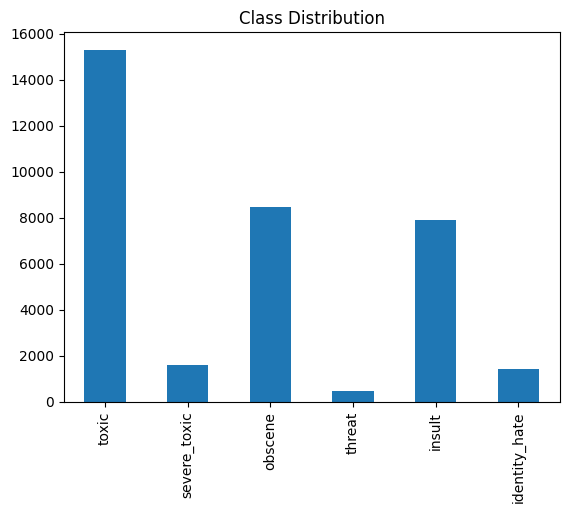

In [13]:
full_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().plot(kind='bar', title='Class Distribution')


<Axes: >

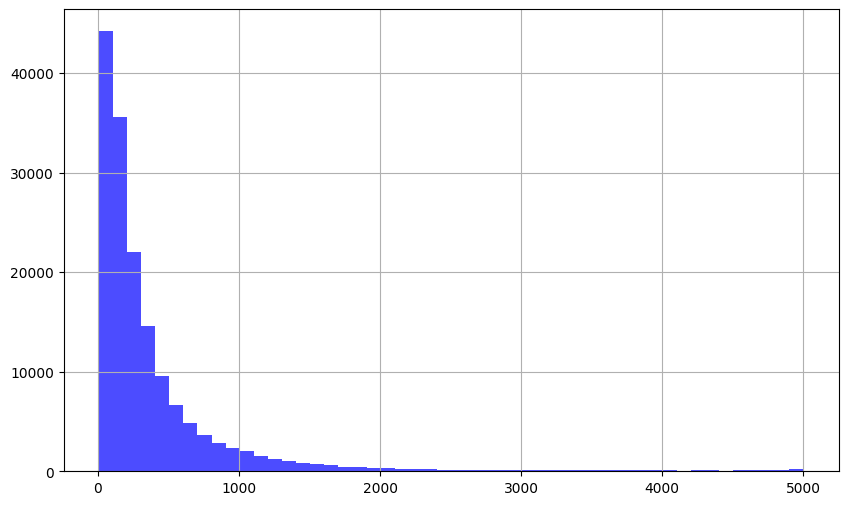

In [14]:
full_data['comment_length'] = full_data['comment_text'].apply(len)
full_data['comment_length'].hist(bins=50, figsize=(10, 6), color='blue', alpha=0.7)


<Axes: >

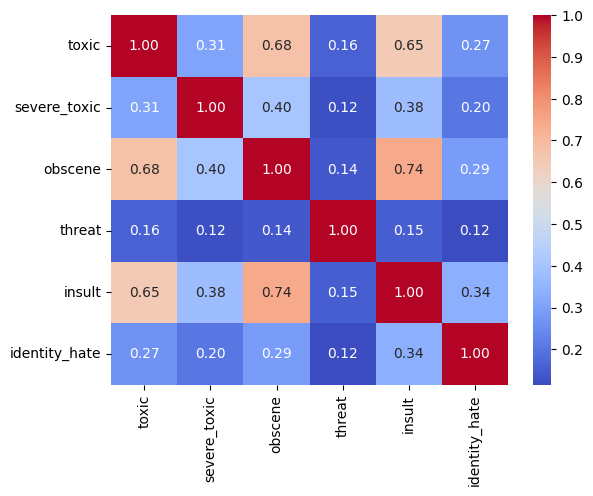

In [15]:
import seaborn as sns
correlation_matrix = full_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")


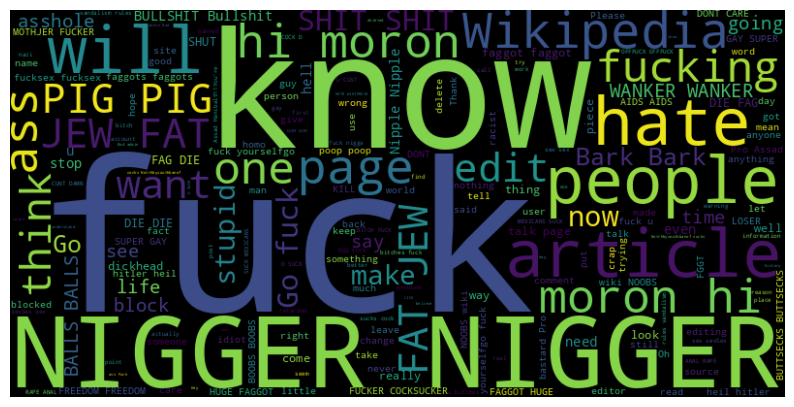

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
toxic_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(full_data[full_data['toxic'] == 1]['comment_text']))
plt.figure(figsize=(10, 6))
plt.imshow(toxic_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


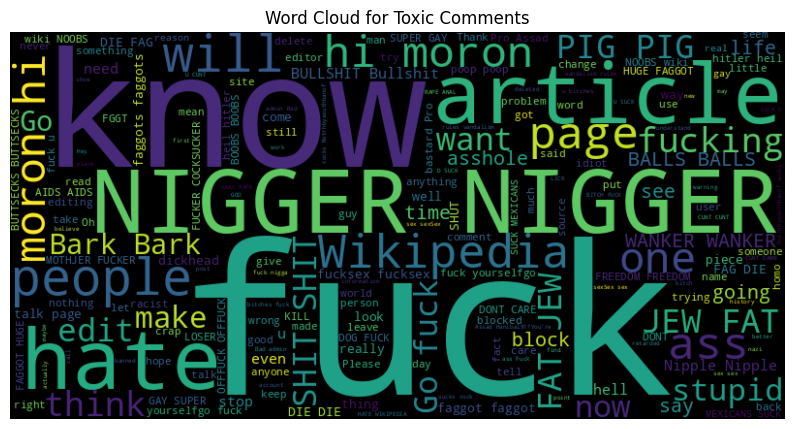

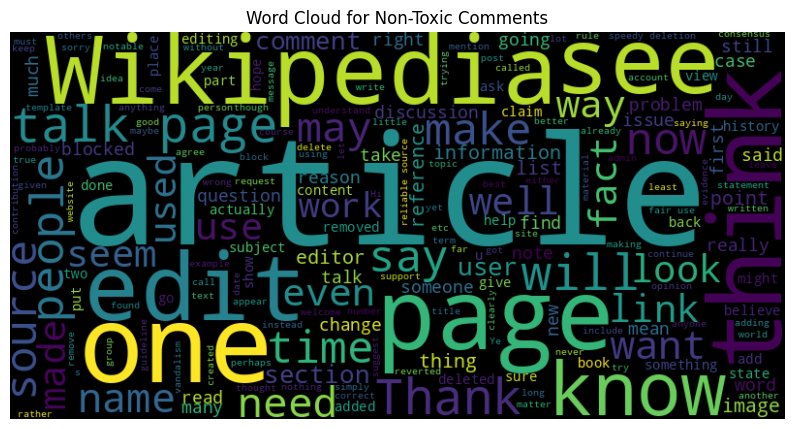

In [18]:
from wordcloud import WordCloud

toxic_comments = full_data[full_data['toxic'] == 1]['comment_text']
non_toxic_comments = full_data[full_data['toxic'] == 0]['comment_text']

# Word Cloud for Toxic Comments
toxic_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(toxic_comments))
plt.figure(figsize=(10, 6))
plt.imshow(toxic_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Toxic Comments')
plt.axis('off')
plt.show()

# Word Cloud for Non-Toxic Comments
non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(non_toxic_comments))
plt.figure(figsize=(10, 6))
plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Non-Toxic Comments')
plt.axis('off')
plt.show()


In [17]:
# Convert the dataframes into tensorflow Dataset objects

train_data = tf.data.Dataset.from_tensor_slices(
    (
        full_data["comment_text"].tolist(),
        full_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.tolist()
    )
)

test_data = tf.data.Dataset.from_tensor_slices(
    (
        test_dataframe["comment_text"].tolist(),
        test_dataframe[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.tolist()
    )
)

In [18]:
batch_size = 128

train_data = train_data.cache().shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().batch(batch_size)

In [19]:
max_tokens = 100000

start = timeit.default_timer()

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    standardize='lower_and_strip_punctuation',
    output_mode="int",
    output_sequence_length=1800
)

text_vectorization.adapt(full_data["comment_text"].tolist())

end = timeit.default_timer()

print(f"It took {end - start} seconds to adapt.")

It took 27.038866919999236 seconds to adapt.


In [20]:
# Remove the unnecessary data

del full_data
del test_dataframe

In [21]:
model = Sequential([
    text_vectorization,
    layers.Embedding(max_tokens+1, 32),
    layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(6, activation="sigmoid")
])

In [22]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=metrics.BinaryAccuracy()
)

In [23]:
train_split = 0.8

train_data = train_data.take(int(len(train_data) * train_split))
valid_data = train_data.skip(int(len(train_data) * train_split))

In [24]:
print("The cardinality of train data is ", train_data.cardinality().numpy())
print("The cardinality of validation data is ", valid_data.cardinality().numpy())
print("The cardinality of test data is ", test_data.cardinality().numpy())

The cardinality of train data is  997
The cardinality of validation data is  200
The cardinality of test data is  500


In [25]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        start_from_epoch=1,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )
]

In [26]:
start = timeit.default_timer()

model_history = model.fit(
    train_data,
    epochs=5,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_data
).history
model.save("/content/drive/MyDrive/Toxic/toxicity_model")
end = timeit.default_timer()

print(f"It took {end - start} seconds to train the model.")

Epoch 1/5
997/997 [==============================] - 206s 200ms/step - loss: 0.0729 - binary_accuracy: 0.9775 - val_loss: 0.0414 - val_binary_accuracy: 0.9832 - lr: 0.0010
Epoch 2/5
997/997 [==============================] - 150s 150ms/step - loss: 0.0441 - binary_accuracy: 0.9833 - val_loss: 0.0415 - val_binary_accuracy: 0.9868 - lr: 0.0010
Epoch 3/5
997/997 [==============================] - 123s 123ms/step - loss: 0.0386 - binary_accuracy: 0.9849 - val_loss: 0.0349 - val_binary_accuracy: 0.9878 - lr: 0.0010
Epoch 4/5
997/997 [==============================] - 118s 119ms/step - loss: 0.0354 - binary_accuracy: 0.9861 - val_loss: 0.0294 - val_binary_accuracy: 0.9890 - lr: 0.0010
Epoch 5/5
997/997 [==============================] - 113s 113ms/step - loss: 0.0322 - binary_accuracy: 0.9872 - val_loss: 0.0283 - val_binary_accuracy: 0.9890 - lr: 0.0010
It took 885.476166507 seconds to train the model.


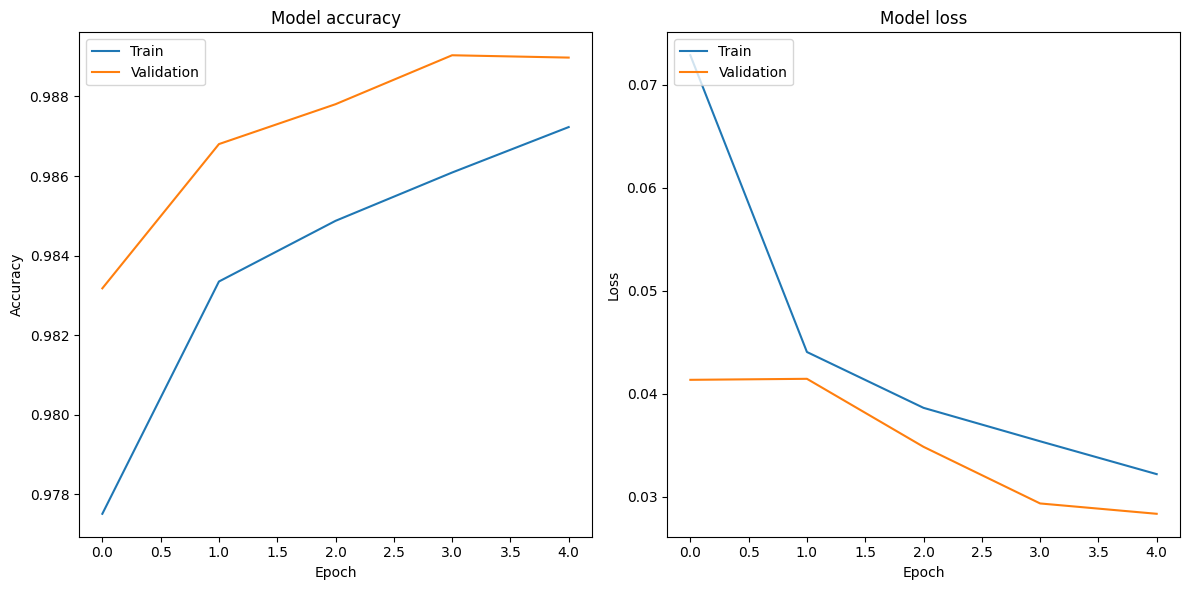

In [27]:
import matplotlib.pyplot as plt
# Plot the training and validation curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(model_history['binary_accuracy'])
plt.plot(model_history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_history['loss'])
plt.plot(model_history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
model.evaluate(test_data)

500/500 [==============================] - 25s 50ms/step - loss: 0.0802 - binary_accuracy: 0.9669


[0.08015754073858261, 0.9669026732444763]

In [38]:
text = "I hate the way you dress , you slut"
predictions = model.predict(np.array([text])) > 0.5
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<{20}}: {predictions[0][i]:<{5}}\n"
print(prediction_text)

1/1 [==============================] - 0s 53ms/step
toxic               : 1    
severe_toxic        : 0    
obscene             : 1    
threat              : 0    
insult              : 1    
identity_hate       : 0    

